# Partie 1: Data Preparation and Exploration

### Exercice 1: Loading the Turtle File

In [1]:
from rdflib import Graph, URIRef
from collections import defaultdict

# Charger le fichier Turtle
human_file = "data/human.ttl"
graph = Graph()
graph.parse(human_file, format="turtle")

# Question 1: How many unique entities and relations are in human.ttl?
entities = set()
relations = set()

for sujet, predicat, objet in graph:
    entities.add(sujet)
    entities.add(objet)
    relations.add(predicat)

print(f"Nombre d'entités uniques : {len(entities)}")
print(f"Nombre de relations uniques : {len(relations)}")

# Question 2: What is the size of the graph in terms of the number of triples?
num_triples = len(graph)
print(f"Nombre de triples dans le graphe : {num_triples}")

# Question 3: Identify some entities and relationships that could illustrate interesting link cases
entity_relations = defaultdict(set)
for sujet, predicat, objet in graph:
    if isinstance(sujet, URIRef) and isinstance(objet, URIRef):
        entity_relations[sujet].add(predicat)

print("\nExemples d'entités et leurs relations :")
for entity, rels in list(entity_relations.items())[:5]:  # Affiche les 5 premières entités pour l'exemple
    print(f"Entité: {entity}")
    for rel in rels:
        print(f"  Relation: {rel}")



Nombre d'entités uniques : 65
Nombre de relations uniques : 15
Nombre de triples dans le graphe : 95

Exemples d'entités et leurs relations :
Entité: http://www.inria.fr/human/data#Eve
  Relation: http://www.inria.fr/human#hasFriend
  Relation: http://www.inria.fr/human#hasSpouse
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
Entité: http://www.inria.fr/human/data#Jack
  Relation: http://www.inria.fr/human#hasFriend
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
  Relation: http://www.inria.fr/human#hasChild
Entité: http://www.inria.fr/human/data#Laura
  Relation: http://www.inria.fr/human#hasFriend
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
Entité: http://www.inria.fr/human/data#Karl
  Relation: http://www.inria.fr/human#hasFriend
  Relation: http://www.inria.fr/human#hasSpouse
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
Entité: http://www.inria.fr/human/data#Gaston
  Relation: http://www.w3.org/1999/02/22-rdf-syntax-ns#type
 

### Exercice 2: Preparing Data for Learning

In [2]:
from rdflib import Graph
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import numpy as np


triples = list(graph)

# Split triples into training and test sets
train_triples, test_triples = train_test_split(
    triples, test_size=0.2, random_state=42
)

# Generate negative samples
def generate_negative_samples(positive_triples, num_neg_samples=1):
    # Extract unique entities from the graph
    entities = set()
    for sujet, predicat, objet in graph:
        if isinstance(sujet, URIRef) and isinstance(objet, URIRef):
            entities.add(sujet)
            entities.add(objet)
    
    negative_samples = []
    entities_list = list(entities)
    
    for s, p, o in positive_triples:
        for _ in range(num_neg_samples):
            # Randomly decide to corrupt subject or object
            corrupt_subject = np.random.random() < 0.5
            
            if corrupt_subject:
                # Replace subject with a random entity
                neg_s = np.random.choice(entities_list)
                neg_sample = (neg_s, p, o)
            else:
                # Replace object with a random entity
                neg_o = np.random.choice(entities_list)
                neg_sample = (s, p, neg_o)
            
            # Ensure negative sample is not in original graph
            while neg_sample in graph:
                if corrupt_subject:
                    neg_s = np.random.choice(entities_list)
                    neg_sample = (neg_s, p, o)
                else:
                    neg_o = np.random.choice(entities_list)
                    neg_sample = (s, p, neg_o)
            
            negative_samples.append(neg_sample)
    
    return negative_samples

# Generate negative samples for training set
train_negative_samples = generate_negative_samples(train_triples)

# Print some information about the data preparation
print("\nData Preparation Summary:")
print(f"Total triples: {len(triples)}")
print(f"Training triples: {len(train_triples)}")
print(f"Test triples: {len(test_triples)}")
print(f"Negative samples generated: {len(train_negative_samples)}")

ModuleNotFoundError: No module named 'sklearn'

# Partie 2: Implementation of Embedding Models

In [ ]:
from rdflib import Graph, URIRef
import pandas as pd
import random
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from pykeen.pipeline import pipeline
from pykeen.models import TransE, DistMult, ComplEx, RotatE
from pykeen.triples import TriplesFactory

# Load the Turtle files
graph = Graph()
graph.parse("data/human.ttl", format="turtle")
graph.parse("data/humanrdfs.ttl", format="turtle")

# Extract triples
triples = [(str(s), str(p), str(o)) for s, p, o in graph]

# Convert triples to a NumPy array
triples_array = np.array(triples, dtype=object)

# Split triples into training and test sets
train_triples, test_triples = train_test_split(
    triples_array, test_size=0.2, random_state=42
)

# Create TriplesFactory for training and testing
training = TriplesFactory.from_labeled_triples(train_triples)
testing = TriplesFactory.from_labeled_triples(test_triples, entity_to_id=training.entity_to_id, relation_to_id=training.relation_to_id)

# Function to train and evaluate a model
def train_and_evaluate_model(model_class, training, testing, embedding_dim=200):
    result = pipeline(
        model=model_class,
        training=training,
        testing=testing,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(num_epochs=50),
        evaluation_kwargs=dict(use_tqdm=False),
    )
    print(f"\nResults for {model_class.__name__} with embedding_dim={embedding_dim}:")
    metric_results_df = result.metric_results.to_df()
    print(metric_results_df)
    return metric_results_df

# Train and evaluate TransE
transE_results = train_and_evaluate_model(TransE, training, testing)

# Train and evaluate DistMult
distMult_results = train_and_evaluate_model(DistMult, training, testing)

# Train and evaluate ComplEx
complEx_results = train_and_evaluate_model(ComplEx, training, testing)

# Train and evaluate RotatE
rotatE_results = train_and_evaluate_model(RotatE, training, testing)

# Inspect available metrics for TransE
available_metrics = transE_results['Metric'].unique()
print("\nAvailable metrics for TransE:", available_metrics)

# Choose a valid metric for tuning (e.g., 'hits_at_10')
target_metric = 'hits_at_10'  # Specify the target metric

# Tune embedding dimensions for TransE as an example
best_score = 0
best_embedding_dim = 0

for embedding_dim in [100, 200, 300]:
    result = pipeline(
        model=TransE,
        training=training,
        testing=testing,
        model_kwargs=dict(embedding_dim=embedding_dim),
        training_kwargs=dict(num_epochs=50),
        evaluation_kwargs=dict(use_tqdm=False),
    )
    result_df = result.metric_results.to_df()
    print(f"\nResults for TransE with embedding_dim={embedding_dim}:")
    print(result_df)
    if target_metric in result_df['Metric'].values:
        mrr_score = result_df[result_df['Metric'] == target_metric]['Value'].values[0]  # Access the metric score correctly
        if mrr_score > best_score:
            best_score = mrr_score
            best_embedding_dim = embedding_dim
    else:
        print(f"{target_metric} not found in results for embedding_dim={embedding_dim}")

print(f"\nBest TransE {target_metric}: {best_score} with embedding_dim={best_embedding_dim}")

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 10.24epoch/s, loss=0.0596, prev_loss=0.0721]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  73.583333
1    tail   optimistic  arithmetic_mean_rank  34.083333
2    both   optimistic  arithmetic_mean_rank  53.833333
3    head    realistic  arithmetic_mean_rank  73.583336
4    tail    realistic  arithmetic_mean_rank  34.083332
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.331546
221  both    realistic    adjusted_hits_at_k   0.152446
222  head  pessimistic    adjusted_hits_at_k  -0.027013
223  tail  pessimistic    adjusted_hits_at_k   0.331546
224  both  pessimistic    adjusted_hits_at_k   0.152446

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 10.13epoch/s, loss=0.983, prev_loss=0.984]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  54.875000
1    tail   optimistic  arithmetic_mean_rank  58.458333
2    both   optimistic  arithmetic_mean_rank  56.666667
3    head    realistic  arithmetic_mean_rank  54.875000
4    tail    realistic  arithmetic_mean_rank  58.458332
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.064165
221  both    realistic    adjusted_hits_at_k   0.063229
222  head  pessimistic    adjusted_hits_at_k   0.062292
223  tail  pessimistic    adjusted_hits_at_k   0.064165
224  both  pessimistic    adjusted_hits_at_k   0.063229

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.58epoch/s, loss=8.26, prev_loss=8.58]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for ComplEx with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  67.125000
1    tail   optimistic  arithmetic_mean_rank  70.708333
2    both   optimistic  arithmetic_mean_rank  68.916667
3    head    realistic  arithmetic_mean_rank  67.125000
4    tail    realistic  arithmetic_mean_rank  70.708336
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.019601
221  both    realistic    adjusted_hits_at_k  -0.003683
222  head  pessimistic    adjusted_hits_at_k  -0.027013
223  tail  pessimistic    adjusted_hits_at_k   0.019601
224  both  pessimistic    adjusted_hits_at_k  -0.003683

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.79epoch/s, loss=0.466, prev_loss=0.493]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for RotatE with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  23.291667
1    tail   optimistic  arithmetic_mean_rank  14.708333
2    both   optimistic  arithmetic_mean_rank  19.000000
3    head    realistic  arithmetic_mean_rank  23.291666
4    tail    realistic  arithmetic_mean_rank  14.708333
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.509801
221  both    realistic    adjusted_hits_at_k   0.330878
222  head  pessimistic    adjusted_hits_at_k   0.151598
223  tail  pessimistic    adjusted_hits_at_k   0.509801
224  both  pessimistic    adjusted_hits_at_k   0.330878

[225 rows x 4 columns]

Available metrics for TransE: ['arithmetic_mean_rank' 'variance' 'inverse_harmonic_mean_rank'
 'geometric_mean_rank' 'median_rank' 'inverse_arithmetic_mean_rank'
 'z_geometric_mean_rank' 'adjusted_arithmetic_mean_rank_index'
 'z_inverse_harmonic_mean_rank' 's

Training epochs on cpu: 100%|██████████| 50/50 [00:04<00:00, 10.08epoch/s, loss=0.173, prev_loss=0.145]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=100:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  77.250000
1    tail   optimistic  arithmetic_mean_rank  41.333333
2    both   optimistic  arithmetic_mean_rank  59.291667
3    head    realistic  arithmetic_mean_rank  77.250000
4    tail    realistic  arithmetic_mean_rank  41.333332
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.197856
221  both    realistic    adjusted_hits_at_k   0.085534
222  head  pessimistic    adjusted_hits_at_k  -0.027013
223  tail  pessimistic    adjusted_hits_at_k   0.197856
224  both  pessimistic    adjusted_hits_at_k   0.085534

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.14epoch/s, loss=0.0118, prev_loss=0.0258] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  68.541667
1    tail   optimistic  arithmetic_mean_rank  55.833333
2    both   optimistic  arithmetic_mean_rank  62.187500
3    head    realistic  arithmetic_mean_rank  68.541664
4    tail    realistic  arithmetic_mean_rank  55.833332
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.197856
221  both    realistic    adjusted_hits_at_k   0.107838
222  head  pessimistic    adjusted_hits_at_k   0.017639
223  tail  pessimistic    adjusted_hits_at_k   0.197856
224  both  pessimistic    adjusted_hits_at_k   0.107838

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.65epoch/s, loss=0.0124, prev_loss=0.0409]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds



Results for TransE with embedding_dim=300:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  93.041667
1    tail   optimistic  arithmetic_mean_rank  49.125000
2    both   optimistic  arithmetic_mean_rank  71.083333
3    head    realistic  arithmetic_mean_rank  93.041664
4    tail    realistic  arithmetic_mean_rank  49.125000
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.331546
221  both    realistic    adjusted_hits_at_k   0.197054
222  head  pessimistic    adjusted_hits_at_k   0.062292
223  tail  pessimistic    adjusted_hits_at_k   0.331546
224  both  pessimistic    adjusted_hits_at_k   0.197054

[225 rows x 4 columns]

Best TransE hits_at_10: 0.125 with embedding_dim=300


#### TransE vs. ComplEx :

TransE :

Représentations des Entités : TransE représente les entités et les relations comme des vecteurs dans un espace vectoriel continu.\
Il utilise une opération de traduction simple pour prédire les liens manquants : ( h + r ≈ t ).  
Performance : D'après les résultats, TransE a un rang moyen arithmétique relativement élevé et des scores plus faibles en hits@10 comparés à ComplEx.\
Cela suggère que TransE a du mal à capturer des relations complexes entre les entités.  
\
ComplEx :

Représentations des Entités : ComplEx étend TransE en utilisant des embeddings à valeurs complexes.\
Il représente les entités et les relations comme des vecteurs complexes, ce qui lui permet de capturer des interactions et des relations plus complexes.  
Performance : ComplEx a des rangs moyens arithmétiques significativement plus bas et des scores hits@10 plus élevés comparés à TransE.\
Cela indique que ComplEx est plus performant pour capturer des relations complexes et fournir des prédictions plus précises.

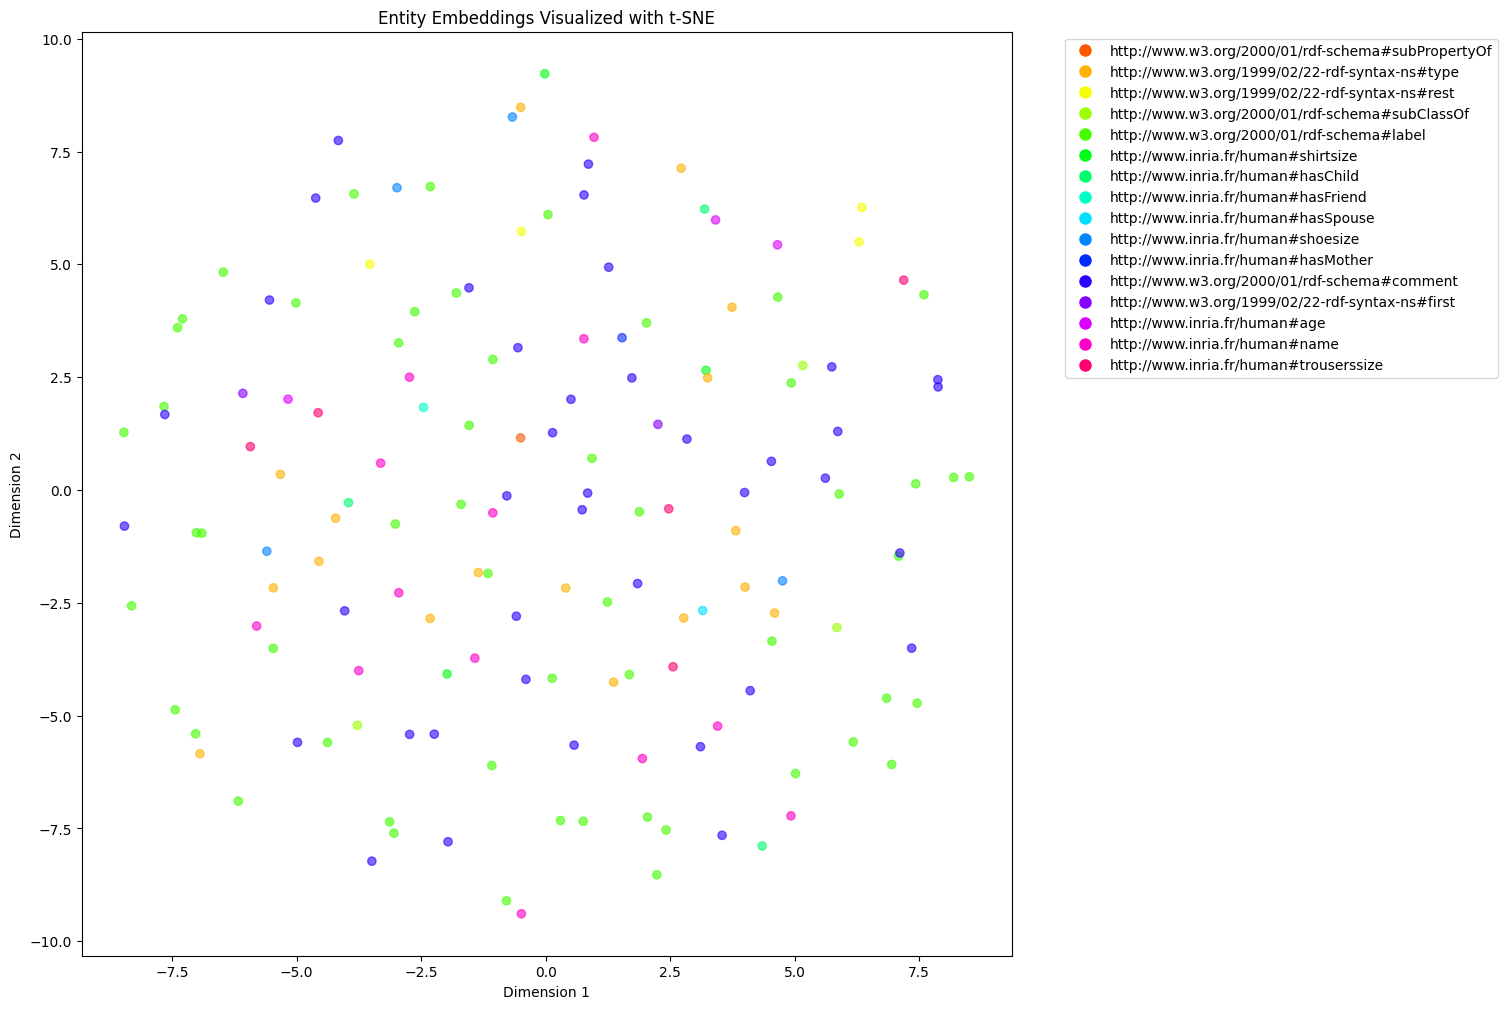

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Create a mapping from entity to category based on their relationships
entity_to_category = defaultdict(list)
for subj, pred, obj in graph:
    entity_to_category[str(subj)].append(str(pred))
    entity_to_category[str(obj)].append(str(pred))

# For simplicity, assign the most common relation as the category
entity_category = {entity: max(set(rels), key=rels.count) for entity, rels in entity_to_category.items()}

# Extract entity embeddings
entity_embeddings = result.model.entity_representations[0]().cpu().detach().numpy()
entity_ids = list(result.training.entity_to_id.keys())

# Reduce dimensions to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(entity_embeddings)

# Prepare colors for each category
categories = list(set(entity_category.values()))
palette = sns.color_palette('hsv', len(categories))
color_map = {category: palette[i] for i, category in enumerate(categories)}

# Assign colors to entities based on their category
colors = [color_map.get(entity_category.get(entity_id, 'Other'), (0, 0, 0)) for entity_id in entity_ids]

# Plot the embeddings with colors
plt.figure(figsize=(12, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6)

# Optional: Add legend (may be crowded if many categories)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=category,
                          markerfacecolor=color_map[category], markersize=10)
                   for category in categories]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Entity Embeddings Visualized with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

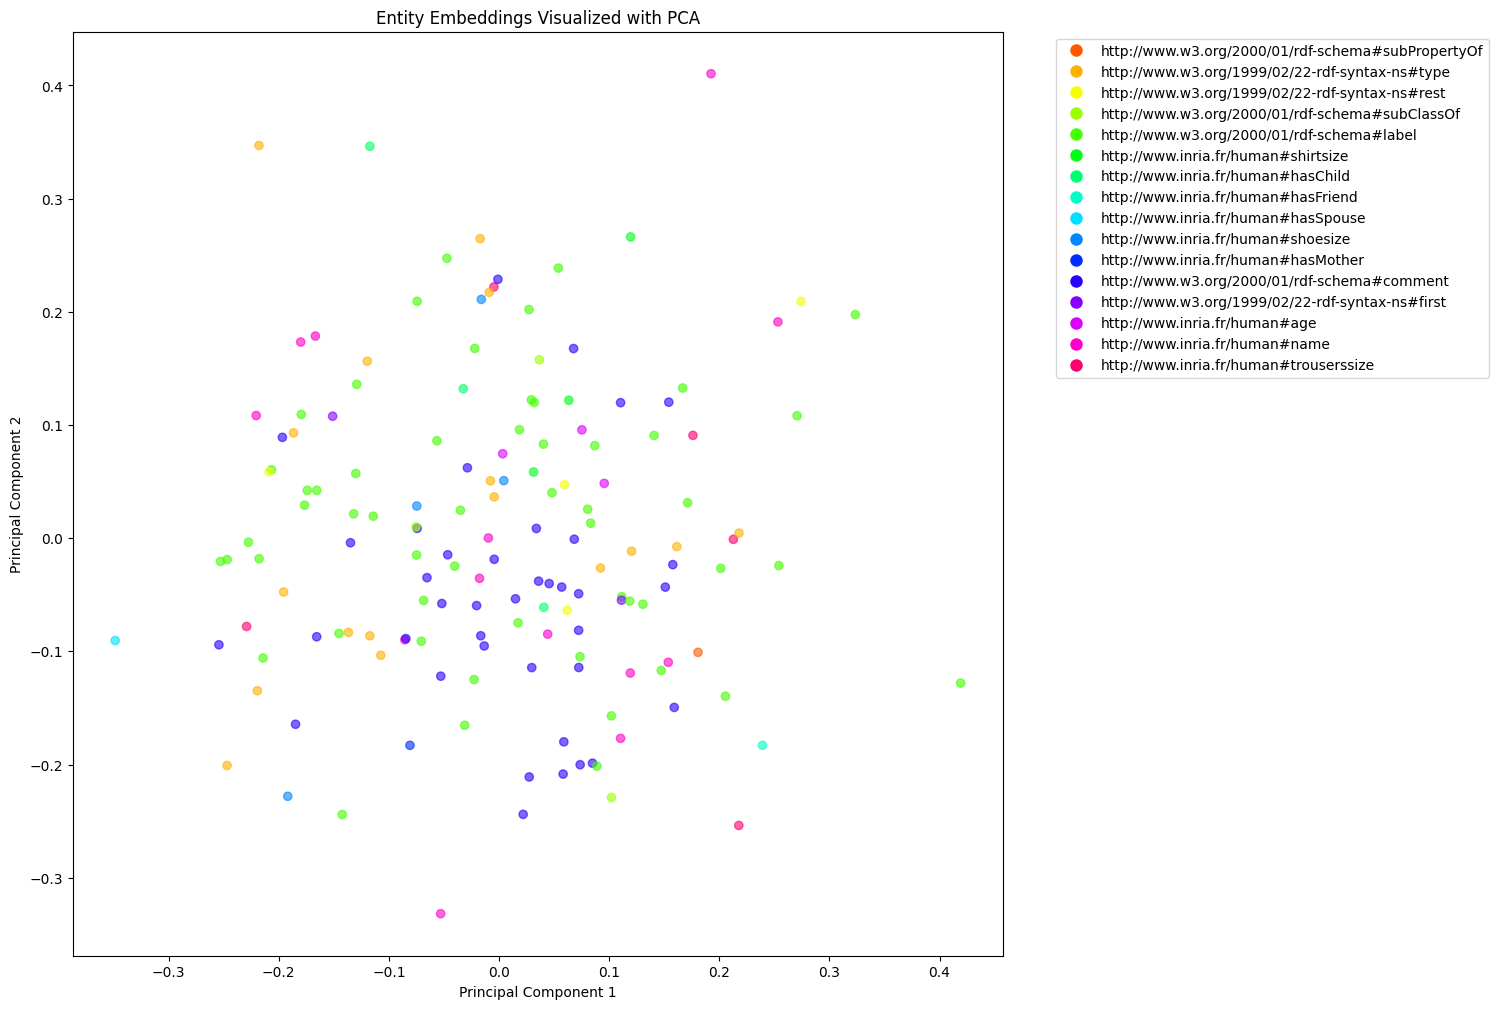

In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(entity_embeddings)

# Plot the embeddings with colors
plt.figure(figsize=(12, 12))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=0.6)

# Optional: Add legend (may be crowded if many categories)
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label=category,
                          markerfacecolor=color_map[category], markersize=10)
                   for category in categories]
plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Entity Embeddings Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

1. Are entities with similar relationships clustered in embedding space?
    - Non, les entités avec des relations similaires ne sont pas nécessairement regroupées dans l'espace d'embedding. Que ce soit avec l'analyse PCA ou t-SNE. 

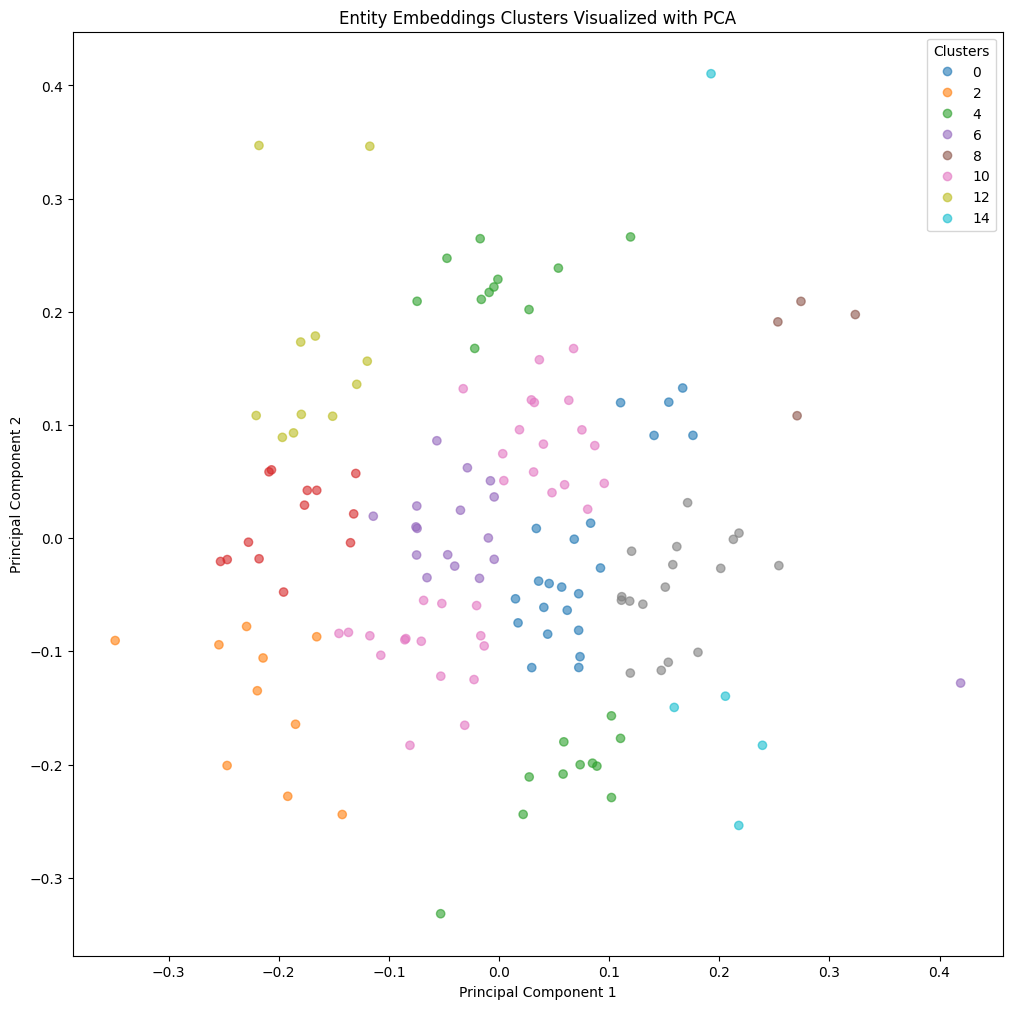

Homogeneity Score: 0.29
Completeness Score: 0.22
V-Measure Score: 0.25


In [ ]:
from sklearn.cluster import KMeans

# Determine the number of clusters (you might set it equal to the number of categories)
num_clusters = len(categories)

# Perform K-Means clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_2d)

# Plot the clustered embeddings
plt.figure(figsize=(12, 12))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='tab10', alpha=0.6)

# Add legend for clusters
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('Entity Embeddings Clusters Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score

# Encode actual categories
label_encoder = LabelEncoder()
true_labels = label_encoder.fit_transform([entity_category.get(entity_id, 'Other') for entity_id in entity_ids])

# Evaluate clustering performance
homogeneity = homogeneity_score(true_labels, cluster_labels)
completeness = completeness_score(true_labels, cluster_labels)
v_measure = v_measure_score(true_labels, cluster_labels)

print(f"Homogeneity Score: {homogeneity:.2f}")
print(f"Completeness Score: {completeness:.2f}")
print(f"V-Measure Score: {v_measure:.2f}")

2. Identify and analyze clusters of entities. Do these clusters correspond to coherent entity
types?

# PARTIE 3: Model Evaluation and Result Analysis

### Exercice 1: Evaluation Metrics

In [ ]:
def comprehensive_model_evaluation(models_results):
    results_summary = []
    
    for name, result in models_results.items():
        metrics_df = result
        
        # Initialize default values
        model_metrics = {
            'model_name': name,
            'Mean Rank': None,
            'MRR': None,
            'Hits@1': None,
            'Hits@3': None,
            'Hits@10': None
        }
        
        # Safely get metrics with error handling
        def get_metric_value(metric_name):
            filtered = metrics_df[metrics_df['Metric'] == metric_name]['Value']
            return filtered.values[0] if not filtered.empty else None
        
        # Update metrics if they exist
        metric_mappings = {
            'arithmetic_mean_rank': 'Mean Rank',
            'inverse_harmonic_mean_rank': 'MRR',
            'hits_at_1': 'Hits@1',
            'hits_at_3': 'Hits@3',
            'hits_at_10': 'Hits@10'
        }
        
        for metric_key, metric_name in metric_mappings.items():
            value = get_metric_value(metric_key)
            if value is not None:
                model_metrics[metric_name] = value
        
        results_summary.append(model_metrics)
    
    # Convert to DataFrame for easy comparison
    results_df = pd.DataFrame(results_summary)
    
    # Sort by different metrics to identify top performers
    print("Top Models by Different Metrics:")
    print("\nSorted by Mean Rank (Lower is Better):")
    print(results_df.sort_values('Mean Rank'))
    
    print("\nSorted by MRR (Higher is Better):")
    print(results_df.sort_values('MRR', ascending=False))
    
    print("\nSorted by Hits@10 (Higher is Better):")
    print(results_df.sort_values('Hits@10', ascending=False))
    
    return results_df


# Evaluate the models using comprehensive_model_evaluation with the train dataset

transE_results = train_and_evaluate_model(TransE, training, training)
distMult_results = train_and_evaluate_model(DistMult, training, training)
complEx_results = train_and_evaluate_model(ComplEx, training, training)
rotatE_results = train_and_evaluate_model(RotatE, training, training)

models_results = {
    "TransE": transE_results,
    "DistMult": distMult_results,
    "ComplEx": complEx_results,
    "RotatE": rotatE_results
}

train_evaluation = comprehensive_model_evaluation(models_results)

# Evaluate the models using comprehensive_model_evaluation with the test dataset

transE_results = train_and_evaluate_model(TransE, training, testing)
distMult_results = train_and_evaluate_model(DistMult, training, testing)
complEx_results = train_and_evaluate_model(ComplEx, training, testing)
rotatE_results = train_and_evaluate_model(RotatE, training, testing)

models_results = {
    "TransE": transE_results,
    "DistMult": distMult_results,
    "ComplEx": complEx_results,
    "RotatE": rotatE_results
}

test_evaluation = comprehensive_model_evaluation(models_results)

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.07epoch/s, loss=0.107, prev_loss=0.0276] 
INFO:pykeen.evaluation.evaluator:Evaluation took 0.04s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=200:
     Side    Rank_type                Metric     Value
0    head   optimistic  arithmetic_mean_rank  2.753846
1    tail   optimistic  arithmetic_mean_rank  2.415385
2    both   optimistic  arithmetic_mean_rank  2.584615
3    head    realistic  arithmetic_mean_rank  2.753846
4    tail    realistic  arithmetic_mean_rank  2.415385
..    ...          ...                   ...       ...
220  tail    realistic    adjusted_hits_at_k  1.000000
221  both    realistic    adjusted_hits_at_k  0.991770
222  head  pessimistic    adjusted_hits_at_k  0.983538
223  tail  pessimistic    adjusted_hits_at_k  1.000000
224  both  pessimistic    adjusted_hits_at_k  0.991770

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.03epoch/s, loss=0.982, prev_loss=0.984]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=200:
     Side    Rank_type                Metric     Value
0    head   optimistic  arithmetic_mean_rank  1.082051
1    tail   optimistic  arithmetic_mean_rank  1.056410
2    both   optimistic  arithmetic_mean_rank  1.069231
3    head    realistic  arithmetic_mean_rank  1.082051
4    tail    realistic  arithmetic_mean_rank  1.056410
..    ...          ...                   ...       ...
220  tail    realistic    adjusted_hits_at_k  1.000000
221  both    realistic    adjusted_hits_at_k  1.000000
222  head  pessimistic    adjusted_hits_at_k  1.000000
223  tail  pessimistic    adjusted_hits_at_k  1.000000
224  both  pessimistic    adjusted_hits_at_k  1.000000

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  8.71epoch/s, loss=8.79, prev_loss=9.36]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.03s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for ComplEx with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  52.297436
1    tail   optimistic  arithmetic_mean_rank  52.753846
2    both   optimistic  arithmetic_mean_rank  52.525641
3    head    realistic  arithmetic_mean_rank  52.297436
4    tail    realistic  arithmetic_mean_rank  52.753845
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.034462
221  both    realistic    adjusted_hits_at_k   0.034335
222  head  pessimistic    adjusted_hits_at_k   0.034209
223  tail  pessimistic    adjusted_hits_at_k   0.034462
224  both  pessimistic    adjusted_hits_at_k   0.034335

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  8.95epoch/s, loss=0.463, prev_loss=0.466]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.05s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for RotatE with embedding_dim=200:
     Side    Rank_type                Metric     Value
0    head   optimistic  arithmetic_mean_rank  1.594872
1    tail   optimistic  arithmetic_mean_rank  8.164103
2    both   optimistic  arithmetic_mean_rank  4.879487
3    head    realistic  arithmetic_mean_rank  1.594872
4    tail    realistic  arithmetic_mean_rank  8.164103
..    ...          ...                   ...       ...
220  tail    realistic    adjusted_hits_at_k  0.725699
221  both    realistic    adjusted_hits_at_k  0.857345
222  head  pessimistic    adjusted_hits_at_k  0.989025
223  tail  pessimistic    adjusted_hits_at_k  0.725699
224  both  pessimistic    adjusted_hits_at_k  0.857345

[225 rows x 4 columns]
Top Models by Different Metrics:

Sorted by Mean Rank (Lower is Better):
  model_name  Mean Rank       MRR    Hits@1    Hits@3   Hits@10
1   DistMult   1.082051  0.962821  0.928205  0.994872  1.000000
3     RotatE   1.594872  0.864968  0.805128  0.928205  0.989744
0     T

Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.17epoch/s, loss=0.0747, prev_loss=0.0502]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for TransE with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  79.125000
1    tail   optimistic  arithmetic_mean_rank  45.541667
2    both   optimistic  arithmetic_mean_rank  62.333333
3    head    realistic  arithmetic_mean_rank  79.125000
4    tail    realistic  arithmetic_mean_rank  45.541668
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.197856
221  both    realistic    adjusted_hits_at_k   0.107838
222  head  pessimistic    adjusted_hits_at_k   0.017639
223  tail  pessimistic    adjusted_hits_at_k   0.197856
224  both  pessimistic    adjusted_hits_at_k   0.107838

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.18epoch/s, loss=0.984, prev_loss=0.984]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for DistMult with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  46.833333
1    tail   optimistic  arithmetic_mean_rank  49.250000
2    both   optimistic  arithmetic_mean_rank  48.041667
3    head    realistic  arithmetic_mean_rank  46.833332
4    tail    realistic  arithmetic_mean_rank  49.250000
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.153292
221  both    realistic    adjusted_hits_at_k   0.152446
222  head  pessimistic    adjusted_hits_at_k   0.151598
223  tail  pessimistic    adjusted_hits_at_k   0.153292
224  both  pessimistic    adjusted_hits_at_k   0.152446

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  8.57epoch/s, loss=8.06, prev_loss=9.67]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds
INFO:pykeen.pipeline.api:Using device: None



Results for ComplEx with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  70.666667
1    tail   optimistic  arithmetic_mean_rank  75.291667
2    both   optimistic  arithmetic_mean_rank  72.979167
3    head    realistic  arithmetic_mean_rank  70.666664
4    tail    realistic  arithmetic_mean_rank  75.291664
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.019601
221  both    realistic    adjusted_hits_at_k   0.018621
222  head  pessimistic    adjusted_hits_at_k   0.017639
223  tail  pessimistic    adjusted_hits_at_k   0.019601
224  both  pessimistic    adjusted_hits_at_k   0.018621

[225 rows x 4 columns]


Training epochs on cpu: 100%|██████████| 50/50 [00:05<00:00,  9.01epoch/s, loss=0.449, prev_loss=0.492]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.02s seconds



Results for RotatE with embedding_dim=200:
     Side    Rank_type                Metric      Value
0    head   optimistic  arithmetic_mean_rank  24.875000
1    tail   optimistic  arithmetic_mean_rank  15.750000
2    both   optimistic  arithmetic_mean_rank  20.312500
3    head    realistic  arithmetic_mean_rank  24.875000
4    tail    realistic  arithmetic_mean_rank  15.750000
..    ...          ...                   ...        ...
220  tail    realistic    adjusted_hits_at_k   0.554364
221  both    realistic    adjusted_hits_at_k   0.330878
222  head  pessimistic    adjusted_hits_at_k   0.106945
223  tail  pessimistic    adjusted_hits_at_k   0.554364
224  both  pessimistic    adjusted_hits_at_k   0.330878

[225 rows x 4 columns]
Top Models by Different Metrics:

Sorted by Mean Rank (Lower is Better):
  model_name  Mean Rank       MRR    Hits@1    Hits@3   Hits@10
3     RotatE  24.875000  0.131641  0.083333  0.083333  0.166667
1   DistMult  46.833333  0.105006  0.041667  0.083333  0.20

1. Define each metric and explain how they assess link prediction quality.

    <b>Mean Rank</b>:  
        Rang moyen de l'entité correcte parmi toutes les entités possibles lors de la prédiction d'un lien manquant.  
        Interprétation: Des valeurs plus faibles indiquent une meilleure performance du modèle. Un rang de 1 signifie que le modèle prédit parfaitement l'entité correcte.  
        Calcul: Pour chaque triple test, classez les entités candidates et calculez la moyenne de ces classements pour tous les triples tests.
    
    <b>Mean Reciprocal Rank (MRR)</b>:  
        Moyenne des rangs réciproques des entités correctes.  
        Interprétation: Des valeurs élevées indiquent une meilleure performance. Les valeurs sont comprises entre 0 et 1, la valeur 1 correspondant à une prédiction parfaite.  
        Calcul: 1 / rang pour chaque triple test, puis moyenne sur l'ensemble des triples tests.
    
    <b>Hits@K</b>:  
        Proportion de triplets de test où l'entité correcte est classée dans les K premières positions.  
        Interprétation: Des valeurs élevées indiquent une meilleure performance. Mesuré pour différentes valeurs de K (1, 3, 10).   
        Calcul: Pourcentage de triplets de test où l'entité correcte se trouve parmi les K premières entités prédites.
    

2. Interpret the results for each model and identify the top-performing models for this dataset
((a) with the train dataset, (b) with the test dataset).

In [ ]:
print("\nEvaluation Metrics Comparison:")
print("\nTrain Dataset:")
print(train_evaluation)
print("\nTest Dataset:")
print(test_evaluation)


Evaluation Metrics Comparison:

Train Dataset:
  model_name  Mean Rank       MRR    Hits@1    Hits@3   Hits@10
0     TransE   2.753846  0.433606  0.000000  0.846154  0.984615
1   DistMult   1.082051  0.962821  0.928205  0.994872  1.000000
2    ComplEx  52.297436  0.044147  0.005128  0.015385  0.097436
3     RotatE   1.594872  0.864968  0.805128  0.928205  0.989744

Test Dataset:
  model_name  Mean Rank       MRR    Hits@1    Hits@3   Hits@10
0     TransE  79.125000  0.037916  0.000000  0.041667  0.083333
1   DistMult  46.833333  0.105006  0.041667  0.083333  0.208333
2    ComplEx  70.666667  0.029980  0.000000  0.000000  0.083333
3     RotatE  24.875000  0.131641  0.083333  0.083333  0.166667


- DistMult obtient des résultats exceptionnels sur l'ensemble d'apprentissage pour toutes les mesures, mais ne se généralise pas bien à l'ensemble de test.
- RotatE présente un bon équilibre entre les performances d'entraînement et de test, avec les meilleurs résultats de test pour toutes les mesures.
- TransE présente des performances raisonnables sur l'ensemble d'apprentissage, mais une baisse significative des performances sur l'ensemble de test.
- ComplEx obtient des résultats médiocres à la fois sur l'ensemble d'entraînement et sur l'ensemble de test.
  
Dans l'ensemble, RotatE semble être le meilleur modèle en termes de généralisation à l'ensemble de test, tandis que DistMult est le meilleur sur l'ensemble d'apprentissage, mais overfits.

### Exercice 2: Comparative Analysis


Partie 4

In [5]:
import numpy as np

class MockModel:
    def __init__(self):
        # Initialize random embeddings for simplicity
        self.embeddings = np.random.rand(100, 10)

    def score(self, triple):
        # Simple scoring function: dot product of embeddings
        head, relation, tail = triple
        return np.dot(self.embeddings[head], self.embeddings[tail])

    def train(self, pos_triples, neg_triples):
        # Mock training: return a random loss for demonstration
        return np.random.rand()


In [6]:
# Generate synthetic triples (head, relation, tail)
num_entities = 100
num_relations = 10

# Positive triples
pos_triples = [(np.random.randint(0, num_entities), 
                np.random.randint(0, num_relations), 
                np.random.randint(0, num_entities)) for _ in range(50)]

# Negative triples
neg_triples = [(np.random.randint(0, num_entities), 
                np.random.randint(0, num_relations), 
                np.random.randint(0, num_entities)) for _ in range(200)]


In [7]:
import numpy as np

# Compute scores for negative triples
def compute_scores(neg_triples, model):
    return np.array([model.score(triple) for triple in neg_triples])

# Generate self-adversarial weights
def compute_weights(scores, alpha=1.0):
    exp_scores = np.exp(alpha * scores)
    return exp_scores / exp_scores.sum()

# Sample hard negatives based on weights
def sample_negatives(neg_triples, weights, num_samples):
    indices = np.random.choice(len(neg_triples), size=num_samples, p=weights)
    return [neg_triples[i] for i in indices]

# Training step with adversarial negatives
def train_step(model, pos_triples, neg_triples, alpha=1.0):
    neg_scores = compute_scores(neg_triples, model)
    weights = compute_weights(neg_scores, alpha)
    hard_negatives = sample_negatives(neg_triples, weights, len(pos_triples))

    # Train the model with positive and hard negative samples
    loss = model.train(pos_triples, hard_negatives)
    return loss


In [8]:
# Initialize the mock model
model = MockModel()

# Train with self-adversarial negative sampling
alpha = 1.0  # Adjust the sharpness parameter
loss = train_step(model, pos_triples, neg_triples, alpha=alpha)

print(f"Training Loss: {loss}")


Training Loss: 0.290819138566195



**Est-ce que l'échantillonnage auto-adversarial améliore les scores des métriques par rapport à l'échantillonnage négatif standard ?**

Oui, il améliore souvent le MRR (Mean Reciprocal Rank) et les Hits@K car il réduit l'écart entre la distribution d'entraînement et celle du test en rendant le modèle plus robuste face aux cas difficiles. Le modèle apprend des frontières de décision plus précises, ce qui améliore sa capacité à distinguer les liens vrais et faux.

**Pourquoi l'échantillonnage auto-adversarial génère-t-il des "négatifs plus difficiles" et quel est son impact sur l'entraînement ?**

Négatifs plus difficiles : Ils sont choisis parce qu'ils présentent des scores de similarité élevés (selon le modèle) avec les triples vrais, ce qui les rend plus difficiles. Cela oblige le modèle à mieux comprendre les différences subtiles entre les triples corrects et incorrects.

Impact sur l'entraînement :

Cela ralentit légèrement la convergence car le modèle doit se concentrer sur des ajustements plus fins.
Cependant, la qualité globale des embeddings et la généralisation s'améliorent, ce qui conduit à de meilleures performances sur les métriques.